# Introduction

In this notebook, we demonstrate the steps needed to create an IoT Edge deployable module from the regression model created in the [turbofan regression](./turbofan_regression.ipynb) notebook. The steps we will follow are:
   1. Reload experiment and model from the Azure Machine Learning service workspace
   1. Create a scoring script
   1. Create an environment YAML file
   1. Create a container image using the model, scoring script and YAML file
   1. Deploy the container image as a web service 
   1. Test the web service to make sure the container works as expected
   1. Delete the web service
   
><font color=gray>Note: this notebook depends on the workspace, experiment and model created in the [turbofan regression](./turbofan_regression.ipynb) notebook.</font>

# Set up notebook

Please ensure that you are running this notebook under the Python 3.6 Kernel. The current kernel is show on the top of the notebook at the far right side of the file menu. If you are not running Python 3.6 you can change it in the file menu by clicking **Kernel->Change Kernel->Python 3.6**

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

## Configure workspace

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **aml_config/config.json** and loads the details into an object named `ws`, which is used throughout the rest of the code in this notebook.

In [2]:
from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.core.model import Model
from azureml.train.automl.run import AutoMLRun

ws = Workspace.from_config()

Found the config file in: /home/nbuser/library/aml_config/config.json


## Load run, experiment and model

In [4]:
import json 

#name project folder and experiment
model_data = json.load(open('./aml_config/model_config.json'))

run_id = model_data['regressionRunId']
experiment_name = model_data['experimentName']
model_id = model_data['modelId']

experiment = Experiment(ws, experiment_name)
automl_run = AutoMLRun(experiment = experiment, run_id = run_id)
model = Model(ws, model_id)

# Create scoring script

The scoring script is the piece of code that runs inside the container and interacts with the model to return a prediction to the caller of web service or Azure IoT Edge module that is running the container. The scoring script is authored knowing the shape of the message that will be sent to the container. In our case, we have chosen to format the message as:

```json
[{
    "DeviceId": 81,
    "CycleTime": 140,
    "OperationalSetting1": 0.0,
    "OperationalSetting2": -0.0002,
    "OperationalSetting3": 100.0,
    "Sensor1": 518.67,
    "Sensor2": 642.43,
    "Sensor3": 1596.02,
    "Sensor4": 1404.4,
    "Sensor5": 14.62,
    "Sensor6": 21.6,
    "Sensor7": 559.76,
    "Sensor8": 2388.19,
    "Sensor9": 9082.16,
    "Sensor10": 1.31,
    "Sensor11": 47.6,
    "Sensor12": 527.82,
    "Sensor13": 2388.17,
    "Sensor14": 8155.92,
    "Sensor15": 8.3214,
    "Sensor16": 0.03,
    "Sensor17": 393.0,
    "Sensor18": 2388.0,
    "Sensor19": 100.0,
    "Sensor20": 39.41,
    "Sensor21": 23.5488
}]
```

><font color='gray'>See the [Azure IoT Edge ML whitepaper](https://aka.ms/IoTEdgeMLPaper) for details about how messages are formatted and sent to the classifier module.</font>

In [38]:
script_file_name = 'score.py'

In [39]:
%%writefile $script_file_name
import pickle
import json
import numpy as np
import pandas as pd
import azureml.train.automl
from sklearn.externals import joblib
from azureml.core.model import Model


def init():
    global model
    model_path = Model.get_model_path(model_name = '<<modelname>>')
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)
    
def unpack_message(raw_data):
    message_data = json.loads(raw_data)
    # convert single message to list 
    if type(message_data) is dict:
        message_data = [message_data]
    return message_data
    
def extract_features(message_data):
    X_data = []
    sensor_names = ['Sensor'+str(i) for i in range(1,22)]
    
    for message in message_data:
        # select sensor data from the message dictionary
        feature_dict = {k: message[k] for k in (sensor_names)}
        X_data.append(feature_dict)
    
    X_df = pd.DataFrame(X_data)
    return np.array(X_df[sensor_names].values)

def append_predict_data(message_data, y_hat):
    message_df = pd.DataFrame(message_data)
    message_df['PredictedRul'] = y_hat
    return message_df.to_dict('records')

def log_for_debug(log_message, log_data):
    print("*****%s:" % log_message)
    print(log_data)
    print("******")

def run(raw_data):
    log_for_debug("raw_data", raw_data)
    
    message_data = unpack_message(raw_data)
    log_for_debug("message_data", message_data)
    
    X_data = extract_features(message_data)
    log_for_debug("X_data", X_data)
   
    # make prediction
    y_hat = model.predict(X_data)
    
    response_data = append_predict_data(message_data, y_hat)
    return response_data

Overwriting score.py


### Update the scoring script with the actual model ID

In [40]:
# Substitute the actual model id in the script file.

with open(script_file_name, 'r') as cefr:
    content = cefr.read()

with open(script_file_name, 'w') as cefw:
    cefw.write(content.replace('<<modelname>>', model.name))

1653

## Create YAML file for the environment

The YAML file provides the information about the dependencies for the model we will deploy. 

### Get azureml versions

First we will use the run to retrieve the version of the azureml packages used to train the model.

In [41]:
best_run, fitted_model = automl_run.get_output()
iteration = int(best_run.get_properties()['iteration'])
dependencies = automl_run.get_run_sdk_dependencies(iteration = iteration)
for p in ['azureml-train-automl', 'azureml-sdk', 'azureml-core']:
    print('{}\t{}'.format(p, dependencies[p]))

azureml-train-automl	1.0.2
azureml-sdk	1.0.2
azureml-core	1.0.2


### Write YAML file 

Write the initial YAML file to disk and update the dependencies for azureml to match with the training versions. This is not strictly needed in this notebook because the model likely has been generated using the current SDK version. However, we include this for completeness fort the case when an experiment was trained using a previous SDK version.

In [42]:
import azureml.core
from azureml.core.conda_dependencies import CondaDependencies

myenv = CondaDependencies.create(conda_packages=['numpy','scikit-learn','pandas'], pip_packages=['azureml-sdk[automl]'])

conda_env_file_name = 'myenv.yml'
myenv.save_to_file('.', conda_env_file_name)

# Substitute the actual version number in the environment file.
with open(conda_env_file_name, 'r') as cefr:
    content = cefr.read()

with open(conda_env_file_name, 'w') as cefw:
    cefw.write(content.replace(azureml.core.VERSION, dependencies['azureml-sdk']))

'myenv.yml'

514

## Create a container image

Use the scoring script and the YAML file to create a container image in the workspace. The image will take several minutes to create.

In [43]:
from azureml.core.image import Image, ContainerImage

image_config = ContainerImage.image_configuration(runtime= "python",
                                 execution_script = script_file_name,
                                 conda_file = conda_env_file_name,
                                 tags = {'area': "digits", 'type': "automl_classification"},
                                 description = "Image for Edge ML samples")

image = Image.create(name = "edgemlsample",
                     # this is the model object 
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)

image.wait_for_creation(show_output = True)

if image.creation_state == 'Failed':
    print("Image build log at: " + image.image_build_log_uri)

Creating image
Running.......................................................................
SucceededImage creation operation finished for image edgemlsample:2, operation "Succeeded"


## Deploy image as a web service on Azure Container Instance

Deploy the image we just created as web service on Azure Container Instance (ACI). We will use this web service to test that our model/container performs as expected. 

In [45]:
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
aci_service_name = 'edge-ml-rul-01'


aci_config = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'area': "digits", 'type': "automl_RUL"}, 
                                               description = 'test service for Edge ML RUL')

print ("Deploying service: %s" % aci_service_name)

aci_service = Webservice.deploy_from_image(deployment_config = aci_config,
                                           image = image,
                                           name = aci_service_name,
                                           workspace = ws)

aci_service.wait_for_deployment(True)
print ("Service state: %s" % aci_service.state)

Deploying service: edge-ml-rul-01
Creating service
Running.........................
SucceededACI service creation operation finished, operation "Succeeded"
Service state: Healthy


## Load test data

To save a couple of steps at this point, we serialized the test data that we loaded in the [turbofan regression](./turbofan_regression.ipynb) notebook. Here we deserialize that data to use it to test the web service.

In [33]:
import pandas as pd
from sklearn.externals import joblib
import numpy

test_df = pd.read_csv("data/WebServiceTest.csv")



In [46]:
test_df.head(1)

,Unnamed: 0,Unit,CycleTime,OperationalSetting1,OperationalSetting2,OperationalSetting3,Sensor1,Sensor2,Sensor3,Sensor4,...,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,MaxCycle,TestEndRUL,RUL,RulClass
0,0,1,1,20.0072,0.7,100.0,491.19,606.67,1481.04,1227.81,...,0.02,362,2324,100.0,24.31,14.7007,230,22,251,Full


## Predict one message at a time

Once the container/model is deployed to and Azure IoT Edge device it will receive messages one at a time. Send a few messages in that mode to make sure everything is working.

In [49]:
import json
import pandas as pd

# reformat data as list of messages
X_message = test_df.head(5).to_dict('record')

result_list = []
for row in X_message:
    row_data = json.dumps(row)
    row_result = aci_service.run(input_data=row_data)
    result_list.append(row_result[0])

result_df = pd.DataFrame(result_list)
residuals = result_df['RUL'] - result_df['PredictedRul']
result_df['Residual'] = residuals
result_df[['CycleTime','RUL','PredictedRul','Residual']]


,CycleTime,RUL,PredictedRul,Residual
0,1,251,225.337547,25.662453
1,2,250,225.708398,24.291602
2,3,249,215.996451,33.003549
3,4,248,241.603630,6.396370
4,5,247,220.353711,26.646289


## Predict entire set

To make sure the model as a whole is working as expected, we send the test set in bulk to the model, save the predictions, and calculate the residual.

In [50]:
import json
import pandas as pd

X_messages = test_df.to_dict('record')
raw_data = json.dumps(X_messages)

result_list = aci_service.run(input_data=raw_data)
result_df = pd.DataFrame(result_list)
residuals = result_df['RUL'] - result_df['PredictedRul']
result_df['Residual'] = residuals

y_test = result_df['RUL']
y_pred = result_df['PredictedRul']

## Plot actuals vs. predicted

To validate the shape of the model, plot the actual RUL against the predicted RUL for each cycle and device.

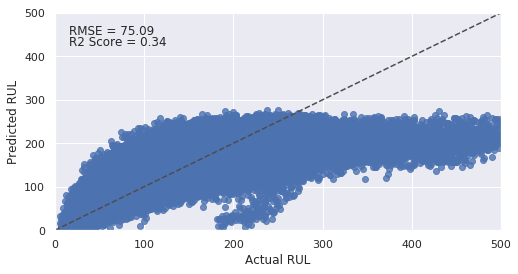

In [51]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, ax = plt.subplots()
fig.set_size_inches(8, 4)

font_size = 12

g = sns.regplot(y='PredictedRul', x='RUL', data=result_df, fit_reg=False, ax=ax)
lim_set = g.set(ylim=(0, 500), xlim=(0, 500))
plot = g.axes.plot([0, 500], [0, 500], c=".3", ls="--");

rmse = ax.text(16,450,'RMSE = {0:.2f}'.format(numpy.sqrt(mean_squared_error(y_test, y_pred))), fontsize = font_size)
r2 = ax.text(16,425,'R2 Score = {0:.2f}'.format(r2_score(y_test, y_pred)), fontsize = font_size)

xlabel = ax.set_xlabel('Actual RUL', size=font_size)
ylabel = ax.set_ylabel('Predicted RUL', size=font_size)


## Delete web service

Now that we are confident that our container and model are working well, delete the web service.

In [52]:
from azureml.core.webservice import Webservice
aci_service = Webservice(ws, 'edge-ml-rul-01')

aci_service.delete()